# 获取原始数据

In [1]:
import os
import sys
import talib as ta
syspath = os.path.split(os.path.abspath("."))[0]
sys.path.append(syspath)
import univ3api.simulation as sim
import univ3api.utils as utils
import importlib
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import pickle
import talib as ta
from dateutil.parser import parse
import numpy as np
# run if simulation file is updated
importlib.reload(sim)

HOST = "mongodb://172.16.20.88:27017/ETHDATA"
source = sim.DataUtilMongoDB(HOST)

from datetime import datetime
import time
d1 = datetime(2021,5,10, 9)
d2 = datetime(2021,11,10,9)
t1 = int(time.mktime(d1.timetuple()))
t2 = int(time.mktime(d2.timetuple()))

# print(d1.timetuple())
# print(time.mktime(d1.timetuple()))
# print(int(time.mktime(d1.timetuple())))

# swapdata = source.swap_by_time("SWAP_WETH_USDT_3000", t1, t2)
swapdata = source.swap_by_time("SWAP_USDC_WETH_500", t1, t2)
swapdata.tail()
pricedata = swapdata[["timestamp", "sqrtPriceX96"]]
# pricedata["price"] = pricedata["sqrtPriceX96"].apply(utils.PriceConverter(18, 6).x96_to_price)
pricedata["price"] = pricedata["sqrtPriceX96"].apply(utils.PriceConverter(6, 18).x96_to_price)
pricedata['datetime']  = pd.to_datetime(pricedata['timestamp'],unit='s')
pricedata['datetime'] = [str(tmp)[:] for tmp in pricedata['datetime'].tolist()]
pricedata

,timestamp,sqrtPriceX96,price,datetime
0,1620608620,1267390127144248068978361798426155,0.000256,2021-05-10 01:03:40
1,1620608625,1267680042870333742156839070397317,0.000256,2021-05-10 01:03:45
2,1620608735,1267817457383972330861871773689515,0.000256,2021-05-10 01:05:35
3,1620609459,1267594782604196631584143944219246,0.000256,2021-05-10 01:17:39
4,1620609550,1268216030588665931252309527014595,0.000256,2021-05-10 01:19:10
...,...,...,...,...
829000,1636441571,1142082588585671647785500155330124,0.000208,2021-11-09 07:06:11
829001,1636441571,1142071759175866417828744621024494,0.000208,2021-11-09 07:06:11
829002,1636441612,1142000969568059491037541876247525,0.000208,2021-11-09 07:06:52
829003,1636441612,1142013920888200672190989935421715,0.000208,2021-11-09 07:06:52


In [2]:
pricedata['datetime'].tolist()[0]

'2021-05-10 01:03:40'

<AxesSubplot:xlabel='datetime'>

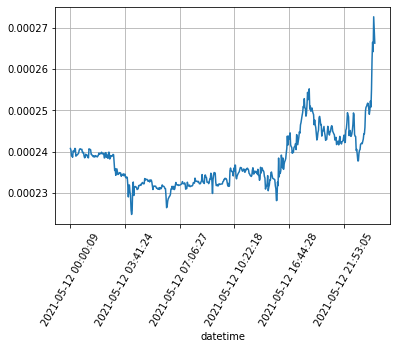

In [3]:
pricedata_plot = pricedata.copy(deep=True)
pricedata_plot = pricedata_plot[pricedata_plot['datetime']<'2021-05-13 00:00:00']
pricedata_plot = pricedata_plot[pricedata_plot['datetime']>'2021-05-12 00:00:00']
pricedata_plot = pricedata_plot[pricedata_plot['datetime']>'2021-05-12 00:00:00']
pricedata_plot.set_index('datetime')['price'].plot(rot = 60,grid=True)
# pricedata_plot.set_index('datetime')['price'].plot(rot = 60)
# pricedata_plot[pricedata_plot['datetime']<'2021-05-15 00:00:00'].set_index('datetime')['price'].plot(rot = 60)

# 指标计算arRollNorm

In [4]:
import pickle
from scipy import stats
def load_obj(name):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)
symbolSigDataAR = load_obj('ARdata/symbolsSigAvg_2018050120211124_60min_v18_ar')['60min']

# AR Rolling Normalization ####################################################
def normalizationProcess(dataArray):
    q75 = np.quantile(dataArray, 0.75)
    q50 = np.quantile(dataArray, 0.5)
    q25 = np.quantile(dataArray, 0.25)
    scaleResult = 100*stats.norm.cdf(0.5*(dataArray[-1]-q50)/(q75-q25))-50
    return scaleResult

def get_ar_norm(df,arCol,WinSize):
    arRollNorm = df[arCol].dropna().rolling(WinSize).apply(normalizationProcess)
    return arRollNorm

ar_param = 144
winsize = 288
symbolSigDataAR[f'arRollNorm{winsize}'] = get_ar_norm(symbolSigDataAR,f'ar{ar_param}',winsize)

startInd = f'{d1.year}-{d1.month}-{d1.day}'
symbolSigDataARRollNorm = symbolSigDataAR.loc[startInd:]
symbolSigDataARRollNormSub = symbolSigDataARRollNorm.reset_index()[[('timestamp',''),(f'arRollNorm{winsize}','')]]
symbolSigDataARRollNormSub.columns = ['datetime',f'arRollNorm{winsize}']
symbolSigDataARRollNormSub['price'] = [np.nan]*len(symbolSigDataARRollNormSub)
symbolSigDataARRollNormSub['sqrtPriceX96'] = [np.nan]*len(symbolSigDataARRollNormSub)
symbolSigDataARRollNormSub['timestamp'] = [np.nan]*len(symbolSigDataARRollNormSub)
symbolSigDataARRollNormSub = symbolSigDataARRollNormSub[['timestamp','sqrtPriceX96','price','datetime',f'arRollNorm{winsize}']]
symbolSigDataARRollNormSub.index = [i for i in range(len(pricedata),len(pricedata)+len(symbolSigDataARRollNormSub))]
symbolSigDataARRollNormSub

pricedataExtend = pricedata.copy(deep=True)
pricedataExtend[f'arRollNorm{winsize}'] = [np.nan]*len(pricedataExtend)
pricedataExtend

datetimeTmp = symbolSigDataARRollNormSub['datetime'].tolist()
datetimeNew = [str(dt)[:-6] for dt in datetimeTmp]
symbolSigDataARRollNormSub['datetime'] = datetimeNew
bar = pricedataExtend.append(symbolSigDataARRollNormSub)

bar = bar.sort_values(by='datetime')
# bar.fillna(method='ffill')
bar = bar.fillna(method='ffill')
pricedata_res_arRollNorm = bar.loc[pricedataExtend.index]
pricedata_res_arRollNorm.set_index('datetime',inplace=True)
pricedata_res_arRollNorm = pricedata_res_arRollNorm[[f'arRollNorm{winsize}']]
pricedata_res_arRollNorm

def load_obj(name):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)
#之后要扩展回测区间时，需要更新此处的基本行情数据
df_eth = load_obj('../../data/usdceth/symbolsData_2018032120211116_60min_v16_E')['60min']
df_eth.columns= ['open','high','low','close','volume']
df_eth = df_eth.loc['2018-03-22':'2021-11-09']
df_eth.reset_index(inplace=True)
df_eth.columns = ['datetime','open','high','low','close','volume']
def cal_indicator(dataCoin):    
    dataCoin['pctChange'] = dataCoin['close'].pct_change()
    dataCoin['pctStd'] = ta.STDDEV(dataCoin['pctChange'], 24*5)*(24**0.5)
    dataCoin['pctStdVma'] = ta.SUM(dataCoin['pctStd']*dataCoin['volume'], 24*50) / ta.SUM(dataCoin['volume'], 24*50)
    dataCoin['closeVma'] = ta.SUM(dataCoin['close']*dataCoin['volume'], 24*50) / ta.SUM(dataCoin['volume'], 24*50)
    dataCoin['pctStdVSma'] = ta.EMA(dataCoin.pctStdVma, 24*3)
    dataCoin['pctStdVLma'] = ta.MA(dataCoin.pctStdVma, 24*10)
    dataCoin['SmaLowerLma'] = dataCoin['pctStdVSma']<dataCoin['pctStdVLma']
    dataCoin['CloseLowerMA'] = dataCoin['close'] < dataCoin['closeVma']
    #根据volResearch notebook里的BelowMA的vol stat中quantile50的2018.5至2021.5波动率统计得出
    dataCoin['VolLowerBelowmaQuantile50'] = dataCoin['pctStd'] < 0.035857 
    #根据volResearch notebook里的OverMA的vol stat中quantile50的2018.5至2021.5波动率统计得出
    dataCoin['VolHigherOvermaQuantile50Twosigma'] = dataCoin['pctStd'] > (0.038511 + 2*0.018451)
    #当波动率高于Belowma的vol stat中的Quantile50的1.05倍时撤销池子
    dataCoin['revoke_pos'] = dataCoin['pctStd'] > 0.035857 *1.05
    
cal_indicator(df_eth)

df_eth_test_period = df_eth[df_eth['datetime']>parse('2021-05-10 00:00:00+00:00')]
df_signal_tmp = df_eth_test_period[['datetime',
                               'SmaLowerLma',
                               'VolLowerBelowmaQuantile50',
                               'CloseLowerMA',
                               'VolHigherOvermaQuantile50Twosigma',
                               'revoke_pos']]
df_signal_tmp['timestamp'] = [0]*len(df_signal_tmp)
df_signal_tmp['sqrtPriceX96'] = [0]*len(df_signal_tmp)
df_signal_tmp['price'] = [0]*len(df_signal_tmp)

df_signal_tmp = df_signal_tmp[['timestamp','sqrtPriceX96','price','datetime',
                 'SmaLowerLma',
                 'VolLowerBelowmaQuantile50',
                 'CloseLowerMA',
                 'VolHigherOvermaQuantile50Twosigma',
                 'revoke_pos']]
df_signal_tmp['datetime_2'] = df_signal_tmp['datetime']
df_signal_tmp = df_signal_tmp.set_index('datetime_2')
# df_signal_tmp = df_signal_tmp.resample('D').first()
df_signal_tmp['datetime'] = [str(tmp)[:-6] for tmp in df_signal_tmp['datetime'].tolist()]
df_signal_tmp['ind'] = [i for i in range(len(pricedata),len(pricedata)+len(df_signal_tmp))]
df_signal_tmp.set_index('ind',inplace=True)
pricedata_tmp = pricedata.append(df_signal_tmp)
pricedata_tmp = pricedata_tmp.sort_values(by='datetime')
pricedata_tmp_beforefill = pricedata_tmp.copy(deep = True)
pricedata_tmp = pricedata_tmp.fillna(method = 'ffill')
pricedata_res = pricedata_tmp.loc[pricedata.index]
pricedata_res.set_index('datetime',inplace=True)

pricedata_res[f'arRollNorm'] = pricedata_res_arRollNorm[f'arRollNorm{winsize}']
pricedata_res

,timestamp,sqrtPriceX96,price,SmaLowerLma,VolLowerBelowmaQuantile50,CloseLowerMA,VolHigherOvermaQuantile50Twosigma,revoke_pos,arRollNorm
datetime,,,,,,,,,
2021-05-10 01:03:40,1620608620,1267390127144248068978361798426155,0.000256,False,False,False,False,True,-15.211088
2021-05-10 01:03:45,1620608625,1267680042870333742156839070397317,0.000256,False,False,False,False,True,-15.211088
2021-05-10 01:05:35,1620608735,1267817457383972330861871773689515,0.000256,False,False,False,False,True,-15.211088
2021-05-10 01:17:39,1620609459,1267594782604196631584143944219246,0.000256,False,False,False,False,True,-15.211088
2021-05-10 01:19:10,1620609550,1268216030588665931252309527014595,0.000256,False,False,False,False,True,-15.211088
...,...,...,...,...,...,...,...,...,...
2021-11-09 07:06:11,1636441571,1142082588585671647785500155330124,0.000208,True,True,False,False,False,-36.889635
2021-11-09 07:06:11,1636441571,1142071759175866417828744621024494,0.000208,True,True,False,False,False,-36.889635
2021-11-09 07:06:52,1636441612,1142000969568059491037541876247525,0.000208,True,True,False,False,False,-36.889635


# 回测

In [5]:
init_price = pricedata_res["price"][0]

decimal0 = 6 #USDC的精度
decimal1 = 18 #ETH的精度

init_amount0 = 1000000*1e6 #初始持有USDC的数量
init_amount1 = 0 #初始持有ETH的数量
print('init_price =',init_price)

init_price = 0.00025589480656772624


# 建池撤池详细信息

In [6]:
import Strategy_usdceth_vol_ar_v1
importlib.reload(utils)
importlib.reload(sim)
importlib.reload(Strategy_usdceth_vol_ar_v1)
strategy = Strategy_usdceth_vol_ar_v1.HoldStrategy(init_amount0, init_amount1, decimal0, decimal1, sim.PoolFee.low, True)
strategy.init(swapdata.iloc[0].to_dict())

# strategy.run(swapdata, priceDt)
strategy.run(swapdata, pricedata_res)

report = strategy.report()

**********************【Price Over MA】【创建Long Vol池子】【第1次建池】***********************************
转换后钱包中余额 amount0:  449725000000.0 amount1:  193083698157521600512
price:  0.0003521544902878512
$$$$$$$【Upper Price】: 0.0004541002285870228
$$$$$$$【Lower Price】: 0.0002730956234392882
######【L】:71422028675099488【USDC】:449725000000【ETH】:162491623721157001216
将要投入池子的数量 amount_t0: 449724999999 amount_t1: 162491623721157263360
【RealWorldTime】:2021-06-04 06:59:28, Timestamp: 1622761168, Blocknumber: 12564357
Mint position： Position(L=71403274644844640, tick=[194220, 199320], range=[2208.3870, 3677.5136])
【Mint amount】: token0=449485.746785, token1=162.49162372115725
Wallet amount: token0=239.253215, token1=30.59207443636434
******************************************【撤销池子】【原因:OverMA与VolHigherQuantile50TwoSigma条件不满足】****************************
CloseLowerMA: True, VolHigherQuantile50TwoSigma: False,arRollNorm:-5.380010306121477
Price(0.0003499691251605845) out of range(0.0002730956234392882, 0.000454

******************************************【撤销池子】【原因:超边撤池】******************************************
Price(0.00033340417946982776) out of range(0.00033383017665992716, 0.0005550889377918559)
【RealWorldTime】:2021-08-07 17:06:08,Timestamp: 1628327168, Blocknumber: 12977018
Decreased position： Position(L=0, tick=[196260, 201300], range=[1811.7120, 2998.9045])
【Decreased amount】: token0=967686.302101, token1=0.9239867105974374
Wallet amount: token0=968081.479842, token1=50.38651674332557
撤池后经转换 Wallet amount: token0=1125288.005488, token1=2.6191977397851605
**********************【Price Over MA】【创建Long Vol池子】【第8次建池】***********************************
转换后钱包中余额 amount0:  506070148269.0 amount1:  209095202863676458911
price:  0.0003334384028223176
$$$$$$$【Upper Price】: 0.0004299659925322548
$$$$$$$【Lower Price】: 0.0002585813073771355
######【L】:78031354040441616【USDC】:506070148269【ETH】:172372042456044175360
将要投入池子的数量 amount_t0: 506070148268 amount_t1: 172372042456044175360
【RealWorldTime】:2021-0

******************************************【撤销池子】【原因:OverMA与VolHigherQuantile50TwoSigma条件不满足】****************************
CloseLowerMA: False, VolHigherQuantile50TwoSigma: False,arRollNorm:5.248661508990914
Price(0.0002909561712119142) out of range(0.00022317050550159573, 0.0003710853227374598)
【RealWorldTime】:2021-09-19 14:59:58,Timestamp: 1632034798, Blocknumber: 13254671
Decreased position： Position(L=0, tick=[192240, 197280], range=[2708.1132, 4482.7064])
【Decreased amount】: token0=512712.320483, token1=167.10719502578166
Wallet amount: token0=516711.404558, token1=208.84448608331647
撤池后经转换 Wallet amount: token0=1197625.134391, token1=10.347539952756712
**********************【Price Over MA】【创建Long Vol池子】【第14次建池】***********************************
转换后钱包中余额 amount0:  538601963565.0 amount1:  203308138532816183118
price:  0.0002932528205050633
$$$$$$$【Upper Price】: 0.0003781470249500108
$$$$$$$【Lower Price】: 0.0002274174092617634
######【L】:78942304541687104【USDC】:538601963565【ETH】:1621

# 获取原始绩效指标

In [7]:
positions = report.positions
positions

{1: <univ3api.simulation.PositionReport at 0x223ca243278>,
 2: <univ3api.simulation.PositionReport at 0x223ca238828>,
 3: <univ3api.simulation.PositionReport at 0x223ca238b38>,
 4: <univ3api.simulation.PositionReport at 0x223ca238f60>,
 5: <univ3api.simulation.PositionReport at 0x223ca238908>,
 6: <univ3api.simulation.PositionReport at 0x223ef8f7438>,
 7: <univ3api.simulation.PositionReport at 0x223ef8f79b0>,
 8: <univ3api.simulation.PositionReport at 0x223ef8f75f8>,
 9: <univ3api.simulation.PositionReport at 0x223ef8f7c50>,
 10: <univ3api.simulation.PositionReport at 0x223ef8f7ef0>,
 11: <univ3api.simulation.PositionReport at 0x223cccba1d0>,
 12: <univ3api.simulation.PositionReport at 0x223cccba438>,
 13: <univ3api.simulation.PositionReport at 0x223cccba6a0>,
 14: <univ3api.simulation.PositionReport at 0x223cccba9b0>,
 15: <univ3api.simulation.PositionReport at 0x223cccbac50>,
 16: <univ3api.simulation.PositionReport at 0x223cccbaef0>,
 17: <univ3api.simulation.PositionReport at 0x224

,datetime,amount0,fee0,cumFee0,collectedFee0,amount1,fee1,cumFee1,collectedFee1
0,2021-07-27 11:59:25,429479.081753,0.000000,0.000000,0.000000,201.874,0.000000e+00,0.000000e+00,0.000000e+00
1,2021-07-27 12:00:03,429476.977462,0.000000,0.000000,0.000000,201.875,4.836314e-07,4.836314e-07,4.836314e-07
2,2021-07-27 12:00:04,429476.951762,0.000000,0.000000,0.000000,201.875,5.906646e-09,4.895380e-07,4.895380e-07
3,2021-07-27 12:00:05,428425.530674,0.000000,0.000000,0.000000,202.358,2.417186e-04,2.422082e-04,2.422082e-04
4,2021-07-27 12:00:05,426557.529965,0.000000,0.000000,0.000000,203.218,4.297899e-04,6.719980e-04,6.719980e-04
...,...,...,...,...,...,...,...,...,...
6059,2021-07-28 08:59:16,520451.601279,0.031614,654.863534,654.863534,161.069,0.000000e+00,2.708551e-01,2.708551e-01
6060,2021-07-28 08:59:41,520463.793431,0.006096,654.869630,654.869630,161.064,0.000000e+00,2.708551e-01,2.708551e-01
6061,2021-07-28 08:59:44,519586.937182,0.000000,654.869630,654.869630,161.448,1.919382e-04,2.710470e-01,2.710470e-01
6062,2021-07-28 08:59:44,519458.972656,0.000000,654.869630,654.869630,161.504,2.801809e-05,2.710750e-01,2.710750e-01


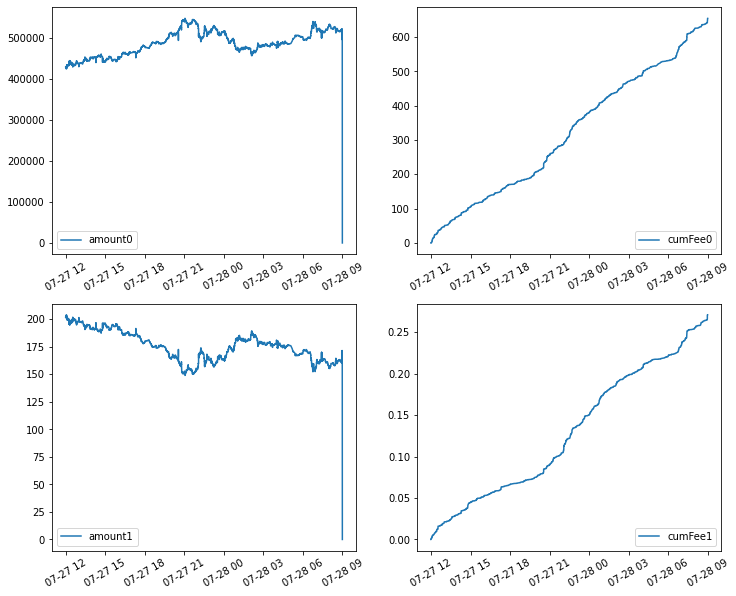

In [8]:
positions[5].get_balance(plain=True, draw_plot=True)

In [9]:
total_balance = report.total_balance(draw_plot=False, plain=True)
backtest_report = total_balance.copy(deep=True)

<AxesSubplot:title={'center':'Total Balance'}>

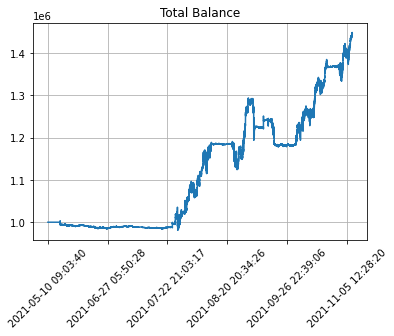

In [10]:
price = pricedata.drop_duplicates("timestamp").set_index("timestamp")["price"]
price
usdc_balance = total_balance.set_index("timestamp")[["amount0NoFee", "cumFee0"]].sum(axis=1)
eth_balance = total_balance.set_index("timestamp")[["amount1NoFee", "cumFee1"]].sum(axis=1) / price
eth_balance+usdc_balance
# eth_balance.plot()
# usdt_balance.plot()
tb_Timing = (eth_balance+usdc_balance)
tb_Timing_origin = tb_Timing.copy(deep=True)
time_to_print = list(map(time.localtime,tb_Timing.index.tolist()))
time_to_print_2  = [time.strftime('%Y-%m-%d %H:%M:%S', i) for i in time_to_print]
# time_to_print_2  = [time.strftime('%Y-%m-%d', i) for i in time_to_print]
tb_Timing.index = time_to_print_2
tb_Timing.plot(rot = 45,grid=True,title='Total Balance')
# tb_Timing.to_csv('../../data/usdceth/tb_timing_v2.csv')
# tb_Timing_origin.to_csv('../../data/usdceth/tb_timing_origin_v2.csv')

In [11]:
eth_balance
eth_balance_df = pd.DataFrame(eth_balance)
eth_balance_df.columns = ['eth_balance']
eth_balance_df

,eth_balance
timestamp,
1620608620,0.000000
1620608625,0.000000
1620608735,0.000000
1620609459,0.000000
1620609550,0.000000
...,...
1636441469,568806.849594
1636441482,568788.010467
1636441498,568756.499465


In [12]:
usdc_balance
usdc_balance_df = pd.DataFrame(usdc_balance)
usdc_balance_df.columns = ['usdc_balance']
usdc_balance_df

,usdc_balance
timestamp,
1620608620,1000000.000000
1620608625,1000000.000000
1620608735,1000000.000000
1620609459,1000000.000000
1620609550,1000000.000000
...,...
1636441469,876124.325419
1636441482,876153.654100
1636441498,876188.481351


In [13]:
tb_Timing

2021-05-10 09:03:40    1.000000e+06
2021-05-10 09:03:45    1.000000e+06
2021-05-10 09:05:35    1.000000e+06
2021-05-10 09:17:39    1.000000e+06
2021-05-10 09:19:10    1.000000e+06
                           ...     
2021-11-09 15:04:29    1.444931e+06
2021-11-09 15:04:42    1.444942e+06
2021-11-09 15:04:58    1.444945e+06
2021-11-09 15:06:11    1.444956e+06
2021-11-09 15:06:52    1.445038e+06
Length: 509255, dtype: float64

# 计算绩效指标

In [14]:
# tb_Timing.resample('D').sum()
pd.to_datetime(tb_Timing.index.tolist()[0])
tb_Timing.index = pd.to_datetime(tb_Timing.index)
tb_Timing.resample('D').last()

2021-05-10    1.000000e+06
2021-05-11    1.000000e+06
2021-05-12    1.000000e+06
2021-05-13    1.000000e+06
2021-05-14    1.000000e+06
                  ...     
2021-11-05    1.395046e+06
2021-11-06    1.384870e+06
2021-11-07    1.417196e+06
2021-11-08    1.439292e+06
2021-11-09    1.445038e+06
Freq: D, Length: 184, dtype: float64

In [15]:
df_tb = pd.DataFrame(tb_Timing.resample('D').last(),columns=['close'])
df_tb['return'] = df_tb['close'].pct_change()
df_tb['return_2'] = df_tb['close']/df_tb['close'].shift(1) - 1
df_tb = df_tb.iloc[:-1,:]
df_tb

,close,return,return_2
2021-05-10,1.000000e+06,NaN,NaN
2021-05-11,1.000000e+06,0.000000,0.000000
2021-05-12,1.000000e+06,0.000000,0.000000
2021-05-13,1.000000e+06,0.000000,0.000000
2021-05-14,1.000000e+06,0.000000,0.000000
...,...,...,...
2021-11-04,1.397214e+06,-0.005431,-0.005431
2021-11-05,1.395046e+06,-0.001552,-0.001552
2021-11-06,1.384870e+06,-0.007294,-0.007294
2021-11-07,1.417196e+06,0.023342,0.023342


<AxesSubplot:>

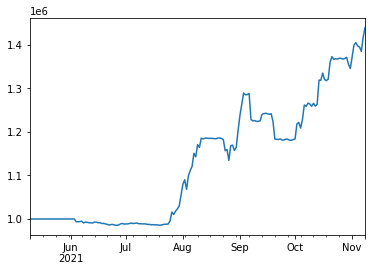

In [16]:
df_tb['close'].plot()

In [17]:
from scipy.stats.mstats import gmean
import math
def max_drawdown(df):
    """
    :return: Max drawdown of the financial series.
    """
    roll_max = df['close'].expanding().max()
    maxDrawdown = -1 * np.min(df['close'] / roll_max - 1)  # 计算得到最大回撤
    return maxDrawdown

def annual_return(df):
    """
    :return: Annual return.
    """
    annualReturn = gmean(df['return'].dropna() + 1) ** 365 - 1  # 得到年化收益率
    return annualReturn

def annual_std(df):
    """
    :return: The annual standard deviation.
    """
    dailyStd = df['return'].std()  # 得到日度波动率
    annualStd = dailyStd * math.sqrt(365)  # 得到年化波动率
    return annualStd

def sharpe_ratio(df):
    """
    :return:  Sharpe ratio.
    """
    annualReturn = annual_return(df)
    annualStd = annual_std(df)
    sharpeRatio = annualReturn / annualStd  # 得到夏普比
    return sharpeRatio

def calmar_ratio(df):
    """
    :return: Calmar ratio.
    """
    annualReturn = annual_return(df)
    maxDrawdown = max_drawdown(df)
    calmarRatio = annualReturn / maxDrawdown
    return calmarRatio

def max_drawdown_duration(df):
    """
    :return: Max Drawdown duration
    """
    xdate = df_tb.index.tolist()
    ycapital = df_tb['close'].tolist()
    duration = []
    tmp_max_capital = ycapital[0]
    for c in ycapital:
        if c >= tmp_max_capital:
            duration.append(0)
        else:
            duration.append(duration[-1]+1)
        tmp_max_capital = max(c, tmp_max_capital)
    MaxDDD = max(duration)
    endidx = np.argmax(duration)
    startidx = endidx - MaxDDD
#     print(xdate[startidx])
#     print(xdate[endidx])
    startD = xdate[startidx]
    endD = xdate[endidx]
#     return MaxDDD, startidx, endidx
    return MaxDDD, startD,endD
    


# 输出绩效

【SWAP_USDC_WETH_500】

USDC手续费 20923.06856 ETH手续费(USDC计价) 26558.53254426877
***************************资金曲线绩效***************************
最大回撤 0.08415794149296463
最长回撤持续期 52 日 起始日期 2021-06-03 00:00:00 结束日期 2021-07-25 00:00:00
年化收益 1.0757108409567993
夏普比率 5.382901041022447
卡尔玛比率 12.782047919348475


<AxesSubplot:title={'center':'Total Balance'}>

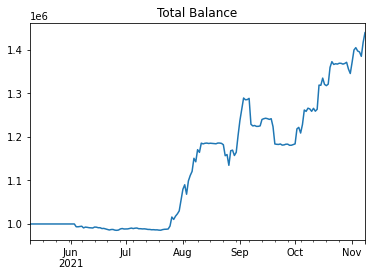

In [18]:
print('【SWAP_USDC_WETH_500】')
print()

cumfee0 = backtest_report['cumFee0'].tolist()[-1]
cumfee1 = backtest_report['cumFee1'].tolist()[-1]/pricedata_res['price'].tolist()[-1]
print('USDC手续费',cumfee0,'ETH手续费(USDC计价)',cumfee1)
print('***************************资金曲线绩效***************************')
print('最大回撤',max_drawdown(df_tb))
print('最长回撤持续期',max_drawdown_duration(df_tb)[0],'日',
      '起始日期',max_drawdown_duration(df_tb)[1],
      '结束日期',max_drawdown_duration(df_tb)[2])
print('年化收益',annual_return(df_tb))
print('夏普比率',sharpe_ratio(df_tb))
print('卡尔玛比率',calmar_ratio(df_tb))
df_tb['close'].plot(title='Total Balance')